# LoC Data Package Tutorial: Digitized Telephone Directories Data Package

This notebook will demonstrate basic usage of using the Pyton library `boto3` for interacting with [data packages from the Library of Congress](https://labs.loc.gov/data/) via the [Digitized Telephone Directories Data Package](https://labs.loc.gov/data/explore/telephone/) which is derived from the Library's [U.S. Telephone Directory Collection](https://www.loc.gov/collections/united-states-telephone-directory-collection/). We will:

1. [Output a summary of the contents of this data package](#Output-data-package-summary)
2. [Read and query metadata from a data package](#Query-the-metadata-in-a-data-package)
3. [Download full text files and visualize it](#Download-full-text-files-and-visualize-it)

## Prerequisites

In order to run this notebook, please follow the instructions listed in [this directory's README](https://github.com/LibraryOfCongress/data-exploration/blob/master/Data%20Packages/README.md).

## Output data package summary

First we will output a summary of the [Digitized Telephone Directories Data Package](https://labs.loc.gov/data/explore/telephone/) contents

In [1]:
import json

import boto3                            # for interacting with Amazon S3 (where the data is stored)
import pandas as pd                     # for reading, manipulating, and displaying data

from helpers import get_s3_bucket_stats

BUCKET_NAME = 'data.labs.loc.gov' # The name of public S3 bucket

# Connect to Amazon S3
s3 = boto3.client('s3')

# This is the name of the data package from the list above; note the trailing slash
DATA_PACKAGE = 'telephone/'

stats = get_s3_bucket_stats(s3, BUCKET_NAME, DATA_PACKAGE)

# Convert to Pandas DataFrame and show table
pd.DataFrame(stats)

,FileType,Count,Size
0,.txt,507,2.44GB
1,.zip,3,1.92GB
2,.json,4,39MB
3,.csv,6,27MB
4,.jsonl,1,23MB
5,.html,3,265KB
6,.pdf,1,219KB
7,.jpg,3,133KB
8,.md,2,34KB


## Query the metadata in a data package

Next we will download a data package's metadata, print a summary of the items' subject values, then filter by a particular location.

All data packages have a metadata file in .json and .csv formats. Let's load the data package's `metadata.json` file:

In [2]:
obj = s3.get_object(Bucket=BUCKET_NAME, Key=f'{DATA_PACKAGE}metadata.json')
contents = obj.get('Body', '[]').read() # Read contents as a string
data = json.loads(contents) # Parse string as JSON
print(f'Loaded metadata file with {len(data):,} entries.')

Loaded metadata file with 3,511 entries.


Next let's convert to pandas DataFrame and print the available properties

In [3]:
df = pd.DataFrame(data)
print(', '.join(df.columns.to_list()))

Date_text, Date, Digitized, Id, IIIF_manifest, Preview_url, Call_number, Type_of_resource, Genre, Location_text, Original_format, Repository, Rights, Source_collection, Title, Mime_type, Online_format, Part_of, Number_of_files, Shelf_id, Url, Last_updated_in_api, Language, Location, Location_ocr


Next print the top 10 most frequent Locations in this dataset

In [8]:
# Since "Locations" are a list, we must "explode" it so there's just one location per row
# We convert to DataFrame so it displays as a table
df['Location_text'].explode().value_counts().iloc[:10].to_frame()

,Location_text
United States -- Illinois -- Chicago,131
United States -- Pennsylvania -- Philadelphia,113
United States -- California -- Los Angeles Central Area,97
United States -- Alabama -- Birmingham,74
United States -- California -- Oakland,74
United States -- California -- San Francisco,71
United States -- Maryland -- Baltimore,63
United States -- California -- Sacramento,51
United States -- California -- San Diego County,47
United States -- Georgia -- Atlanta,46


Now we filter the results to only those items with Location "United States -- Alabama -- Birmingham"

In [13]:
df_by_location = df.explode('Location_text')
subset = df_by_location[df_by_location.Location_text == 'United States -- Alabama -- Birmingham']
print(f'Found {subset.shape[0]:,} items with location "United States -- Alabama -- Birmingham"')

Found 74 items with location "United States -- Alabama -- Birmingham"


## Download full text files and visualize it

First we download the file manifest.

In [14]:
obj = s3.get_object(Bucket=BUCKET_NAME, Key=f'{DATA_PACKAGE}manifest.json')
contents = obj.get('Body', '[]').read() # Read contents as a string
data = json.loads(contents) # Parse string as JSON
files = [dict(zip(data["cols"], row)) for row in data["rows"]] # zip columns and rows
files_by_id = dict([(f['item_id'], f['filename']) for f in files]) # create a dict that we can use to easily look up filenames
print(f'Loaded manifest file with {len(files):,} entries.')

Loaded manifest file with 486 entries.


Next we load the OCR text of the items in the subset if they exist

In [16]:
found = 0
text = ''
for i, row in subset.iterrows():
    # Derive the filename from the item's id
    item_id = row["Id"]
    if item_id in files_by_id:
        filename = files_by_id[item_id]
        obj = s3.get_object(Bucket=BUCKET_NAME, Key=f'{DATA_PACKAGE}data/{filename}')
        contents = obj.get('Body', '').read() # Read contents as a string
        text += contents.decode("utf-8")
        text += '\n'
        found += 1
print(f'Found and loaded {found:,} OCR text files')

Found and loaded 74 OCR text files


Finally generate a wordcloud using the text

(-0.5, 399.5, 199.5, -0.5)

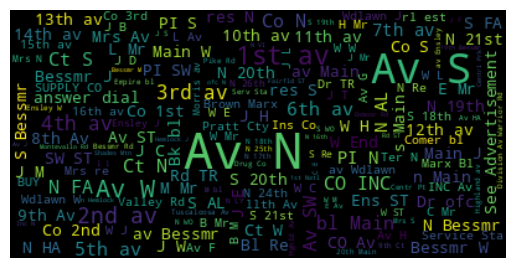

In [17]:
import matplotlib.pyplot as plt         # for displaying data
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")